<a href="https://colab.research.google.com/github/deriiinjv/pytorch-ml-experiments/blob/main/FasgionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time
%matplotlib inline

In [2]:
def set_seeds():
  seed_val=43
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_val)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_set=datasets.FashionMNIST(root="F_MNIST_data",download=True,train=True,transform=transform)
val_set=datasets.FashionMNIST(root="F_MNIST_data",download=True,train=False,transform=transform)
print("Total Train Img",len(train_set))
print("Total Val Img",len(val_set))

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]

Total Train Img 60000
Total Val Img 10000


In [4]:
train_loader=torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=64)
val_loader=torch.utils.data.DataLoader(val_set,shuffle=False,batch_size=64)

In [5]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

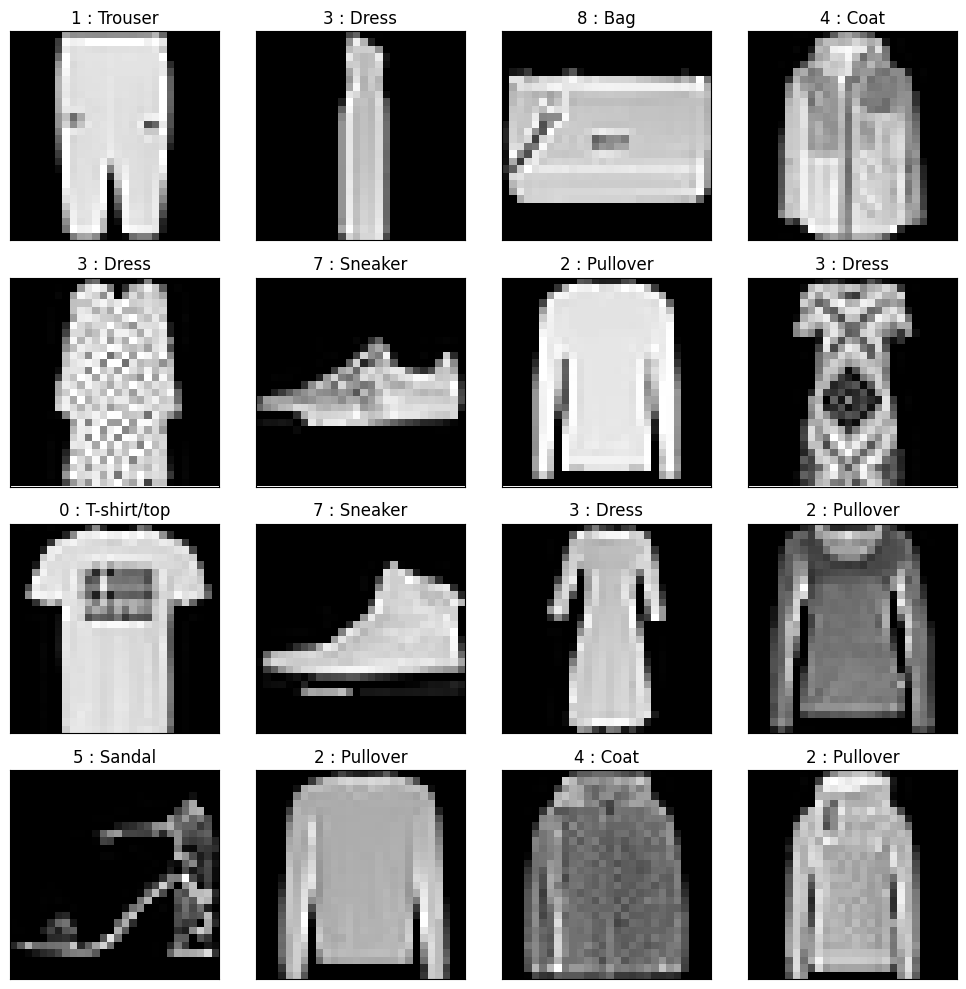

In [6]:
def visualize(train_loader, num_images=16):
    fig = plt.figure(figsize=(10, 10))

    images, labels = next(iter(train_loader))

    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1)

        image = images[idx]
        label = labels[idx]

        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title(f"{label.item()} : {class_mapping[label.item()]}")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
visualize(train_loader)

In [7]:
class MLP(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.fc0=nn.Linear(784,512)
    self.bn0=nn.BatchNorm1d(512)
    self.fc1=nn.Linear(512,256)
    self.bn1=nn.BatchNorm1d(256)
    self.fc2=nn.Linear(256,128)
    self.bn2=nn.BatchNorm1d(128)
    self.fc3=nn.Linear(128,64)
    self.bn3=nn.BatchNorm1d(64)
    self.fc4=nn.Linear(64,num_classes)
    self.dropout=nn.Dropout(p=0.3)
  def forward(self,x):
    x=x.view(x.shape[0],-1)
    x=F.relu(self.bn0(self.fc0(x)))
    x=self.dropout(x)
    x=F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x=F.relu(self.bn3(self.fc3(x)))
    x=F.log_softmax(self.fc4(x),dim=1)
    return x
mlp_model=MLP(num_classes=10)

In [8]:
!pip install torchinfo
from torchinfo import summary

In [9]:
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.58
Input size (MB): 0.

In [25]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2)
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
def train(model, trainloader, criterion, optimizer,DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [27]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [28]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [29]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

Epoch 01/40 - Train Loss: 0.4357, Train Accuracy: 84.28% - Val Loss: 0.3827, Val Accuracy: 86.07%
Epoch 02/40 - Train Loss: 0.3803, Train Accuracy: 86.11% - Val Loss: 0.3635, Val Accuracy: 86.65%
Epoch 03/40 - Train Loss: 0.3512, Train Accuracy: 87.09% - Val Loss: 0.3891, Val Accuracy: 86.03%
Epoch 04/40 - Train Loss: 0.3318, Train Accuracy: 87.65% - Val Loss: 0.3530, Val Accuracy: 87.34%
Epoch 05/40 - Train Loss: 0.3158, Train Accuracy: 88.34% - Val Loss: 0.3267, Val Accuracy: 88.12%
Epoch 06/40 - Train Loss: 0.3011, Train Accuracy: 88.86% - Val Loss: 0.3266, Val Accuracy: 88.20%
Epoch 07/40 - Train Loss: 0.2915, Train Accuracy: 89.13% - Val Loss: 0.3123, Val Accuracy: 88.51%
Epoch 08/40 - Train Loss: 0.2796, Train Accuracy: 89.82% - Val Loss: 0.3141, Val Accuracy: 88.54%
Epoch 09/40 - Train Loss: 0.2727, Train Accuracy: 89.81% - Val Loss: 0.3042, Val Accuracy: 89.08%
Epoch 10/40 - Train Loss: 0.2623, Train Accuracy: 90.08% - Val Loss: 0.3130, Val Accuracy: 88.79%
Epoch 11/40 - Train 

KeyboardInterrupt: 

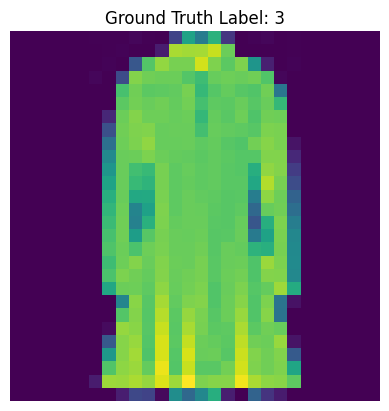

In [30]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()